In [1]:
import pandas as pd
import numpy as np  # linear algebra
import string
import re
import sys
import os

import jellyfish # library for fuzzy text comparisons

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)

In [2]:
PATH_TO_GLOVE = './glove.840B.300d.txt' #840 billion word version

In [3]:
try:
    sys.path.append(os.path.expanduser(PATH_TO_FAISS))
    import faiss #Needs wvpy2 env
    FAISS_AVAILABLE = True
except:
    FAISS_AVAILABLE = False

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

# Make the jupyter notebook cells wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
def get_all_glove(glove_path):
    # create word_vec with glove vectors
    glove_dict = {}
    with open(glove_path) as f:
        for line in tqdm(f):
            word, vec = line.split(' ', 1)
            glove_dict[word] = np.array(list(map(float, vec.split())), dtype=np.float32)
    return glove_dict

In [6]:
# Load the GloVe vectors into a dictionary
glove = get_all_glove(PATH_TO_GLOVE)

In [7]:
# Convert the dictionary to an embedding matrix, a dictionary mapping from word to id, and a list which will map from id to word
emb = np.zeros((len(glove), 300), dtype=np.float32)
w2id = {}
id2w=[]
for cc, word in enumerate(glove.keys()):
    emb[cc]=glove[word]
    w2id[word]=cc
    id2w.append(word)

#For faiss specifically
emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

In [8]:
if FAISS_AVAILABLE:
    d = emb.shape[1]                            # will be 300 - it's the number of dimensions of each word vector
    # index = faiss.IndexFlatL2(d)
    index = faiss.IndexFlatIP(d)                # This creates the index
    index.add(emb)                              # This adds all the word vectors to the index
    print(index.ntotal, 'words now in index')


In [10]:
def getNeighbours(word_list, transform_vector=0, c=1.0, neighbours=10, metric='cosine', use_faiss=FAISS_AVAILABLE):
    word_embeds = np.vstack([emb[w2id[x]] for x in word_list]) # create a numpy array of word embeddings
    if use_faiss:
        distances, indices = index.search(
            (word_embeds - transform_vector*c).astype(np.float32), neighbours)
    else:
        dist_matrix = cdist((word_embeds - transform_vector*c).astype(np.float32), emb, metric=metric)
        indices = np.argsort(dist_matrix)[:, :neighbours]
    return indices

def toWords(index_list, n=10):
    res = []
    for ind in index_list:
        # if n=1 convert to a simple list rather than a nested list
        if n==1:
            res.append(id2w[ind[0]])
        else:
            res.append([id2w[x] for x in ind[:n]])
    return res

In [11]:
%time toWords(getNeighbours(['reliable', 'relieable']), n=10)

CPU times: user 2.49 s, sys: 1.01 s, total: 3.51 s
Wall time: 3.51 s


[['reliable',
  'dependable',
  'trustworthy',
  'cost-effective',
  'efficient',
  'economical',
  'Reliable',
  'accurate',
  'reliability',
  'trusted'],
 ['relieable',
  'relyable',
  'realible',
  'relable',
  'reliabe',
  'realiable',
  'relaiable',
  'relaible',
  'trustworth',
  'trustfull']]

In [13]:
print toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - emb[w2id['king']], c=1), n=5)
print toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - .7*emb[w2id['king']], c=1), n=5)
print toWords(getNeighbours(['foriegn'], emb[w2id['relieable']] - emb[w2id['reliable']], c=1), n=5)
print toWords(getNeighbours(['made'], emb[w2id['took']] - emb[w2id['take']], c=1.5), n=5)
print toWords(getNeighbours(['dog'], emb[w2id['man']] - emb[w2id['boy']], c=1.5), n=5)
print toWords(getNeighbours(['amd'], 0, c=-1.5), n=10)

[['queen', 'king', 'prince', 'princess', 'kings'], ['queen', 'king', 'princess', 'prince', 'kings'], ['king', 'prince', 'queen', 'kings', 'princess']]
[['queen', 'king', 'princess', 'queens', 'Queen'], ['princess', 'queen', 'girl', 'king', 'princesses'], ['king', 'prince', 'queen', 'princess', 'boy']]
[['foreign', 'foriegn', 'reliable', 'overseas', 'need']]
[['make', 'can', 'you', 'take', 'give']]
[['puppy', 'dog', 'puppies', 'kitten', 'pup']]
[['amd', 'athlon', 'pentium', 'intel', 'cpu', 'ati', 'asus', 'nvidia', 'geforce', 'celeron']]


In [15]:
mistakes = pd.read_csv('Oxford_common_spellings.csv')
mistakes.head()

,correct,incorrect
0,accommodate,accomodate
1,accommodation,accomodation
2,achieve,acheive
3,across,accross
4,aggressive,agressive


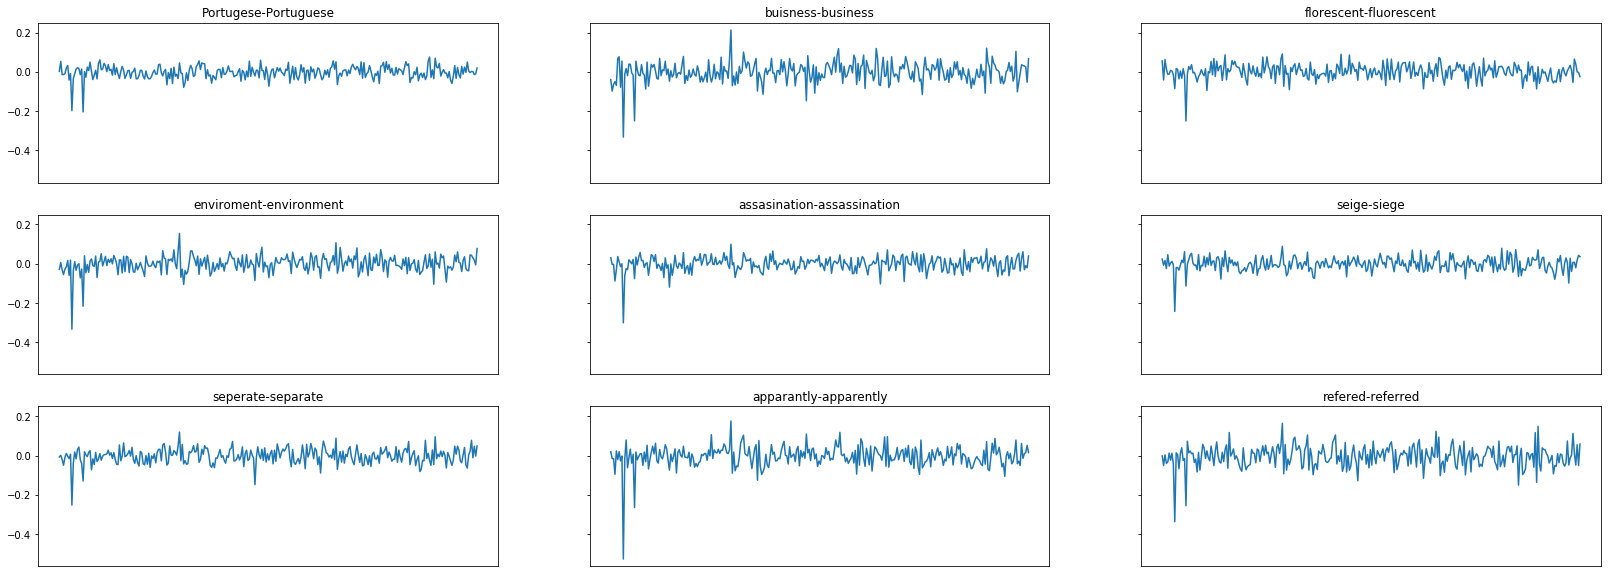

In [16]:
# This is just to help me reproduce the same chart. Comment out this line and uncomment the next line if you want to look at a new random selection word pairs 
samp = mistakes.loc[[76, 31, 90, 14, 9, 6, 36, 91, 84]]
# samp = mistakes.sample(9)

fig, ax = plt.subplots(3, 3, sharey=True)
fig.set_size_inches(28, 10, forward=True)
i = 0
j = 0
for row in samp.itertuples():
    ax[i][j].set_title(row.incorrect + '-' + row.correct)
    ax[i][j].xaxis.set_visible(False)
#     ax[i][j].yaxis.set_visible(False)

    vec = emb[w2id[row.incorrect]]-emb[w2id[row.correct]]
    ax[i][j].plot(vec)
#     ax[i][j].bar(x=list(range(300)), height=vec, color=cmap(np.abs(vec)), width=1)
    i += 1
    if i == 3:
        i = 0
        j += 1

17


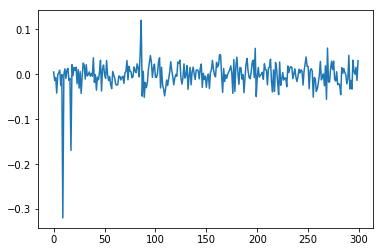

In [23]:
train, test = train_test_split(mistakes, train_size=0.85, random_state=42)
spell_transform = np.zeros((300,))
for row in train.itertuples():
    spell_transform += emb[w2id[row.incorrect]] - emb[w2id[row.correct]]
spell_transform /= len(train)

plt.plot(spell_transform)
print(len(test))

In [25]:
# See how the transformation performs on the test set
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format(1.0*(test.fixed==test.correct).sum()/len(test)*100.0))

8 correct out of 17
Accuracy on test set: 47.06%


In [26]:
# See how the transformation performs on the test set
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1.5), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format(1.0*(test.fixed==test.correct).sum()/len(test)*100))

16 correct out of 17
Accuracy on test set: 94.12%


      correct incorrect     fixed
18  chauffeur  chauffer  chauffer


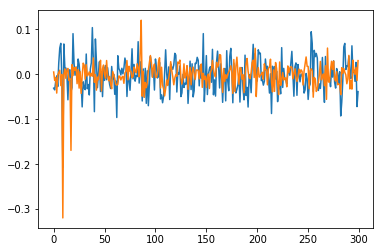

In [29]:
print test[test.fixed!=test.correct]
# plt.plot(emb[w2id['Farenheit']]-emb[w2id['Fahrenheit']])
plt.plot(emb[w2id['chauffer']]-emb[w2id['chauffeur']])
plt.plot(spell_transform)

In [30]:
mistakes['lev_score'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect) / max(len(x.correct), len(x.incorrect)), axis=1)
mistakes['lev_distance'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect), axis=1)
mistakes.sort_values('lev_distance').tail()

TypeError: ('unicode argument expected', u'occurred at index 0')